# Quickstart

Here we provide a standard use case for `Pyatoa` which includes data gathering, misfit assessment, and saving and aggregating data. We'll treat this example as the first function evaluation in a seismic inversion.

We'll be using the [M6.2 Eketahuna earthquake in New Zealand](https://www.geonet.org.nz/earthquake/story/2014p051675) as our test event, and collecting seismic waveform data from the broadband seismic network of New Zealand [(GeoNet)](https://www.geonet.org.nz/data/network/sensor/search).

In [6]:
from pyasdf import ASDFDataSet
from pyatoa import logger, Config, Manager, Inspector

logger.setLevel("DEBUG")

First we open an `ASDFDataSet`, which we will attach to our `Manager` object and use for data storage.

In [3]:
path_to_data = "../tests/test_data/scratch/2018p130600.h5"
event_id = "2018p130600"
ds = ASDFDataSet(dataset_fileid)

Next we instantiate a `Config` object. Let's suppose this is the first function evaluation of a hypothetical seismic inversion, so we set the `iteration` to 1 and `step_count` to 0. 

In [4]:
cfg = Config(iteration=1, step_count=0, 
             event_id="2018p130600",
             client="GEONET",
             min_period=10, max_period=30,
             pyflex_preset="nznorth_10-30s_plus", 
             adj_src_type="cc_traveltime_misfit",
             )

Finally we instantiate our `Manager` object which will perform the heavy lifting in our misfit assesment workflow. 

In [5]:
mgmt = Manager(config=cfg, ds=ds)

Let's event metadata for this earthquake, a moment tensor will automatically be appended from the GeoNet moment tensor catalog. This will not be the case for other regions, but the ability to query the GCMT catalog is available.

In [7]:
mgmt.gather(choice="event")

[2020-08-12 16:12:43] - pyatoa - DEBUG: gathering event
[2020-08-12 16:12:43] - pyatoa - DEBUG: event ID: 2018p130600, querying client GEONET
[2020-08-12 16:12:44] - pyatoa - DEBUG: matching event found: 2018p130600
[2020-08-12 16:12:45] - pyatoa - INFO: geonet moment tensor found for: 2018p130600
[2020-08-12 16:12:45] - pyatoa - DEBUG: GeoNet moment tensor is in units of Newton*meters
[2020-08-12 16:12:45] - pyatoa - INFO: GeoNet moment tensor appended to Event
[2020-08-12 16:12:45] - pyatoa - DEBUG: event QuakeML added to ASDFDataSet


Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:nz.org.geonet/2018p130600
    station   [inv]:       None
    observed  [st_obs]:    0
    synthetic [st_syn]:    0
Stats and Status
    half_dur:              0
    time_offset_sec:       0
    standardized:          False
    obs_filtered:          False
    syn_filtered:          False
    nwin (windows):        0
    misfit (adjsrcs):      0.00E+00

Now we'll gather observation waveforms (st_obs) and station metadata (inv) for the station [NZ.WEL](https://www.geonet.org.nz/data/network/sensor/WEL), located in Wellington, New Zealand. We can use wildcards in the channel code to gather all available components, which are N, E and Z. Under the hood, Pyatoa is calling the ObsPy FDSN webservice client.

In [8]:
mgmt.gather(code="NZ.WEL.??.HH?", choice=["inv", "st_obs"])

[2020-08-12 16:23:29] - pyatoa - INFO: gathering data for NZ.WEL.??.HH?
[2020-08-12 16:23:29] - pyatoa - INFO: gathering observed waveforms
[2020-08-12 16:23:29] - pyatoa - DEBUG: searching ASDFDataSet
[2020-08-12 16:23:29] - pyatoa - DEBUG: searching local filesystem
[2020-08-12 16:23:29] - pyatoa - DEBUG: querying client GEONET
[2020-08-12 16:23:31] - pyatoa - INFO: matching observed waveforms found
[2020-08-12 16:23:31] - pyatoa - INFO: saved to ASDFDataSet with tag 'observed'
[2020-08-12 16:23:31] - pyatoa - INFO: gathering StationXML
[2020-08-12 16:23:31] - pyatoa - DEBUG: searching ASDFDataSet
[2020-08-12 16:23:31] - pyatoa - DEBUG: searching local filesystem
[2020-08-12 16:23:31] - pyatoa - DEBUG: querying client GEONET
/Users/Chow/miniconda3/envs/tomo/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
[2020-08-12 16:23:32] 

Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:nz.org.geonet/2018p130600
    station   [inv]:       NZ.WEL
    observed  [st_obs]:    3
    synthetic [st_syn]:    0
Stats and Status
    half_dur:              0
    time_offset_sec:       0
    standardized:          False
    obs_filtered:          False
    syn_filtered:          False
    nwin (windows):        0
    misfit (adjsrcs):      0.00E+00

Unfortunately we can't easily gather synthetic data (st_syn), as this needs to be generated using an external numerical solver. Instead, we'll modulate the phase and amplitude of our observed data by convolving it with a triangle function, and use that as our synthetic data.

[2020-08-12 16:31:24] - pyatoa - DEBUG: convolved data w/ Gaussian (t/2=10.00s)


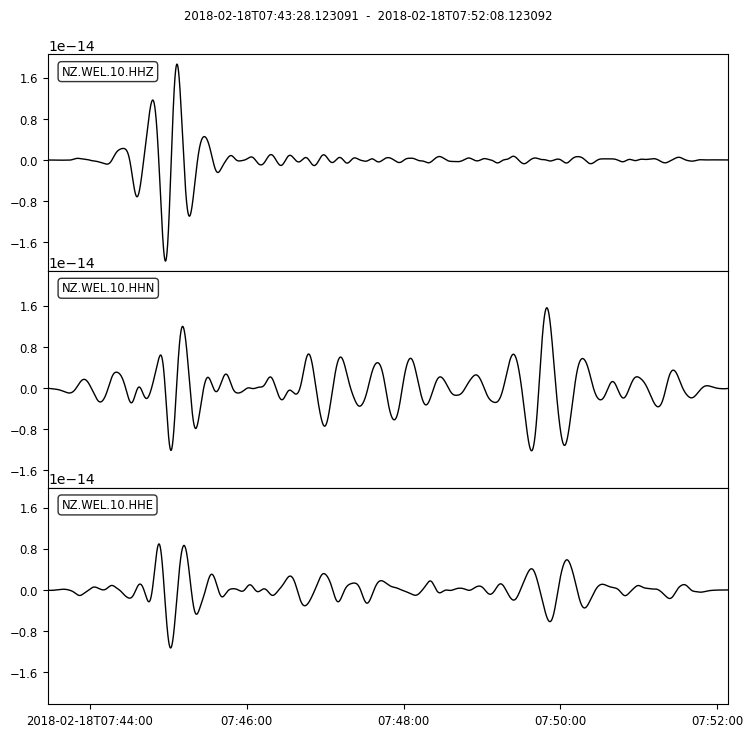

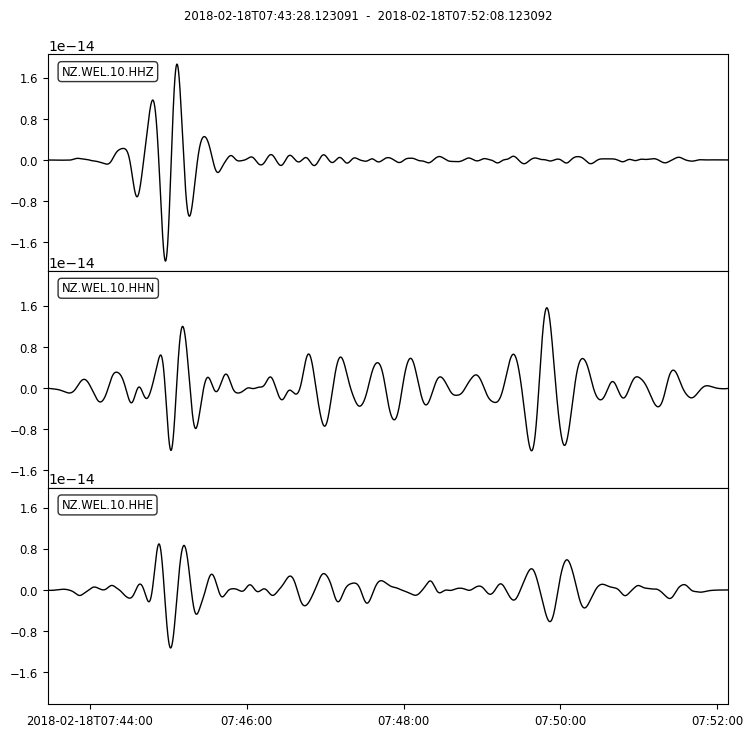

In [12]:
def generate_synthetic_data(mgmt):
    """
    """
    from pyatoa.utils.process import stf_convolve

    st_syn = mgmt.st_obs.copy()
    st_syn.remove_response(inventory=mgmt.inv, output="DISP")
    st_syn = stf_convolve(st_syn, half_duration=10.)
    
    return st_syn

mgmt.st_syn = generate_synthetic_data(mgmt)
mgmt.st_syn.plot()       

[2020-08-12 16:31:32] - pyatoa - INFO: data already standardized
/Users/Chow/Documents/academic/vuw/packages/pyatoa/pyatoa/visuals/map_maker.py:151: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  area_thresh=area_thresh, ax=ax,


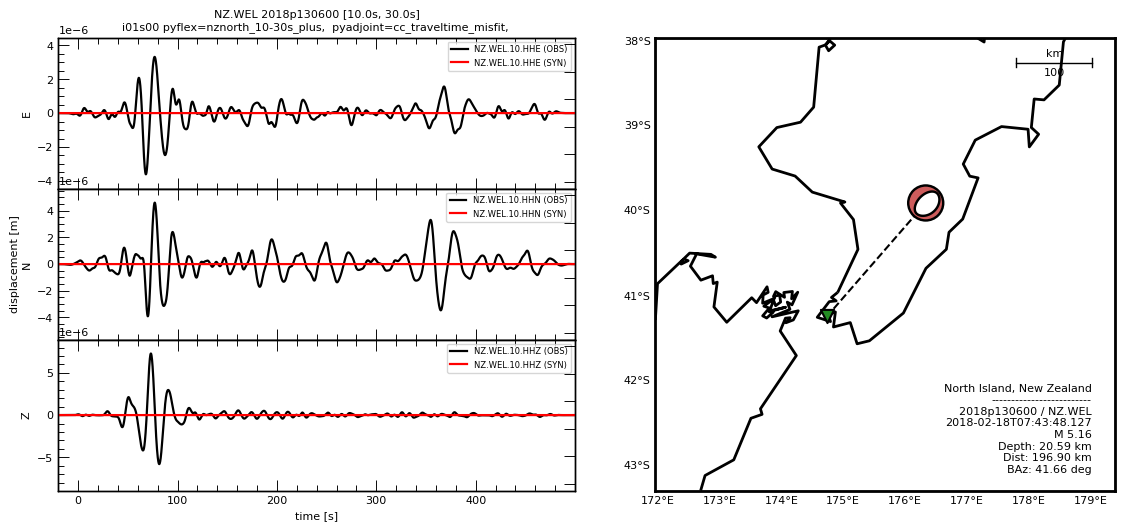

In [13]:
mgmt.standardize().preprocess().plot()